In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from BOCC import BOCC, load_clusters
import os
import networkx as nx
import numpy as np
import sys
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont



pd.set_option('precision', 8)
pd.set_option("display.precision", 8)
# Functions for usefull stuff
def remove_borders(ax,top=True,right=True,bottom=True,left=True):
    ax.spines['top'].set_visible(not top)
    ax.spines['right'].set_visible(not right)
    ax.spines['bottom'].set_visible(not bottom)
    ax.spines['left'].set_visible(not left)

/Users/michael/miniconda3/envs/bocc/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
# load the 2021 clusters
g_coms = load_clusters('../SubComs/2021/paris.greedy.2021.coms.txt')
w_coms = load_clusters('../SubComs/2021/paris.walktrap.2021.coms.txt')
i_coms = load_clusters('../SubComs/2021/paris.infomap.2021.coms.txt')
c_coms = load_clusters('../SubComs/2021/paris.cesna.2021.coms.txt')
G21 = nx.read_edgelist('../Edgelists/String_HPO_2021.phenotypic_branch.edgelist.txt')
all_coms = [g_coms,w_coms,i_coms,c_coms]
all_names = ['paris.greedy','paris.walktrap','paris.infomap','paris.cesna']

In [3]:
# create a dictionary of the degrees of each gene in string
g21_genes = [ n for n in G21.nodes if 'HP:' not in n]
string_degree = { g:len([x for x in G21.neighbors(g) if 'HP:' not in x]) for g in g21_genes}

In [4]:
rh_hpo = 'HP:0000007'
# get a list of recessive genes
recessive_genes = [line.strip().split('\t')[1] 
                   for line in open('../Resources/genes_to_phenotype.Nov_29_2022.txt','r') 
                   if rh_hpo in line]
print(len(recessive_genes))

3473


In [5]:
# list of olfactory genes
xls = pd.ExcelFile('../Resources/12864_2020_6583_MOESM2_ESM.xlsx')
xdf = xls.parse('Human')
# print(xdf)
of_genes = set(list(xdf['Gene symbol']))
print(of_genes)
print(len(of_genes))
print('Number of Olfactory Genes in G21',sum([g in G21.nodes for g in of_genes]))
# Double check the Olfactory genes are all in trivial coms
of_genes_in_trivial_coms = set()
of_genes_non_trivial_coms = set()
for coms,name in zip(all_coms,all_names):
    for com in coms:
        genes = com.get_genes()
        hpos = [n for n in com.members if n not in genes]
        if len(genes) == 0 or len(hpos) == 0 or len(com.members) < 0:
            for g in of_genes:
                if g in genes:
                    of_genes_in_trivial_coms.add(g)
        else:
            for g in of_genes:
                if g in genes:
                    of_genes_non_trivial_coms.add(g)
print('Number of OF genes in trivial coms',len(of_genes_in_trivial_coms))
print('Number of OF genes in Non-trivial coms',len(of_genes_non_trivial_coms))

{'OR4C16', 'OR7E158P', 'OR52B4', 'OR7E83P', 'OR7E97P', 'OR51B8P', 'OR2AL1P', 'RP11-94P11.3', 'OR4G4P', 'OR2AS1P', 'OR5BR1P', 'OR2L13', 'OR10A4', 'OR4R2P', 'OR10U1P', 'OR7E47P', 'OR2A12', 'OR7A10', 'OR10G5P', 'OR3A3', 'OR8U1', 'OR4D7P', 'OR10G4', 'OR8B10P', 'OR4A13P', 'OR5B17', 'OR8K2P', 'OR4C12', 'OR4S1', 'OR1E3', 'OR4A18P', 'OR10D5P', 'OR4A1P', 'OR2G2', 'OR4W1P', 'OR2A4', 'OR51A1P', 'OR4B1', 'OR7G1', 'OR2W1', 'OR10J5', 'OR8F1P', 'OR2AS2P', 'OR5J1P', 'OR2T8', 'OR5M5P', 'OR1L3', 'OR4H6P', 'OR6E1P', 'OR2W5', 'OR5AK3P', 'OR6C1', 'OR4K11P', 'OR51B4', 'OR14L1P', 'OR2T3', 'OR8H1', 'OR4S2', 'OR2T27', 'OR4D1', 'OR1X5P', 'OR10AB1P', 'OR7E89P', 'OR10Y1P', 'OR5J7P', 'OR6W1P', 'OR11L1', 'OR10D1P', 'OR8G2P', 'OR52B6', 'OR10AA1P', 'OR2B6', 'OR5AP1P', 'OR6K2', 'OR4A10P', 'OR8K3', 'OR5H6', 'OR56A5', 'OR9H1P', 'OR4F3', 'OR2T10', 'OR4A43P', 'OR4E2', 'OR1P1', 'OR2M5', 'OR4C1P', 'OR5G1P', 'OR52A1', 'OR5AK1P', 'OR6C72P', 'OR8I1P', 'OR4F2P', 'OR52B2', 'OR10J3', 'OR14K1', 'OR51B3P', 'OR4A3P', 'OR2R1P', 'OR10

Number of OF genes in trivial coms 382
Number of OF genes in Non-trivial coms 193


In [6]:
haplo_genes_df = pd.read_csv('../Resources/haploinsufficient_genes_curation_results.csv')
print(haplo_genes_df.columns)
print(haplo_genes_df.shape)
# the Gene column has names listed like "ENSG00000167548:KMT2D" - I only want the symbol
haplo_genes = [ x.split(':')[1] for x in haplo_genes_df['Gene']]

Index(['Variant ID', 'Gene', 'Should Revisit', 'Verdict', 'Flag Mapping Error',
       'Flag Genotyping Error', 'Flag Homopolymer', 'Flag No Read Data',
       'Flag Reference Error', 'Flag Strand Bias', 'Flag Mnp',
       'Flag Essential Splice Rescue', 'Flag Minority Of Transcripts',
       'Flag Weak Exon Conservation', 'Flag Last Exon',
       'Flag Other Transcript Error', 'Flag Partial Exon Conservation',
       'Flag Weak/Unrecognized Splice Rescue',
       'Flag Low Relative Mean Pext/Pext Does Not Support Splicing',
       'Flag Weak Gene Conservation', 'Flag Uninformative Pext',
       'Flag Coverage Issue'],
      dtype='object')
(403, 22)


In [7]:
# gnomad.v2.1.1.lof_metrics.by_gene.txt
constaint = pd.read_csv('../Resources/gnomad.v2.1.1.lof_metrics.by_gene.txt', sep='\t')
print(constaint.columns)
print(constaint.shape)
print(constaint['oe_lof'])

Index(['gene', 'transcript', 'obs_mis', 'exp_mis', 'oe_mis', 'mu_mis',
       'possible_mis', 'obs_mis_pphen', 'exp_mis_pphen', 'oe_mis_pphen',
       'possible_mis_pphen', 'obs_syn', 'exp_syn', 'oe_syn', 'mu_syn',
       'possible_syn', 'obs_lof', 'mu_lof', 'possible_lof', 'exp_lof', 'pLI',
       'pNull', 'pRec', 'oe_lof', 'oe_syn_lower', 'oe_syn_upper',
       'oe_mis_lower', 'oe_mis_upper', 'oe_lof_lower', 'oe_lof_upper',
       'constraint_flag', 'syn_z', 'mis_z', 'lof_z', 'oe_lof_upper_rank',
       'oe_lof_upper_bin', 'oe_lof_upper_bin_6', 'n_sites', 'classic_caf',
       'max_af', 'no_lofs', 'obs_het_lof', 'obs_hom_lof', 'defined', 'p',
       'exp_hom_lof', 'classic_caf_afr', 'classic_caf_amr', 'classic_caf_asj',
       'classic_caf_eas', 'classic_caf_fin', 'classic_caf_nfe',
       'classic_caf_oth', 'classic_caf_sas', 'p_afr', 'p_amr', 'p_asj',
       'p_eas', 'p_fin', 'p_nfe', 'p_oth', 'p_sas', 'transcript_type',
       'gene_id', 'transcript_level', 'cds_length', 'num_codi

In [8]:
# for each gene count the number of possible new edges (number of HPOs in it's cluster it is not connected to)
counts_dict = {'algo':[],'com':[],'gene':[],'count':[]}
for coms,name in zip(all_coms,all_names):
    for com in coms:
        genes = com.get_genes()
        hpos = [n for n in com.members if n not in genes]
        if len(genes) == 0 or len(hpos) == 0 or len(com.members) < 3:
            continue
        for g in genes:
            count = 0
            for h in hpos:
                if not G21.has_edge(g,h):
                    count += 1
            counts_dict['algo'].append(name)
            counts_dict['com'].append(com.name)
            counts_dict['gene'].append(g)
            counts_dict['count'].append(count)
counts_df = pd.DataFrame(counts_dict)
counts_df['haplo'] = [ g in haplo_genes for g in counts_df['gene']]
counts_df['haplo_color'] = ['red' if x else 'blue' for x in counts_df['haplo']]
counts_df['recessive_gene'] = [g in recessive_genes for g in counts_df['gene']]
counts_df['olfactory'] = [g in of_genes for g in counts_df['gene']]
counts_df['string_degree'] = [string_degree[g] for g in counts_df['gene']]
# mark what type a gene is, it can only be one type for this analysis
# trumping in this order
# haplo > olfactory > recessive > other
def gene_type(row):
    if row['haplo']:
        return 'haplo'
    elif row['olfactory']:
        return 'olfactory'
    elif row['recessive_gene']:
        return 'recessive_gene'
    else:
        return 'other'
counts_df['type'] = [ gene_type(counts_df.iloc[i,:]) for i in range(counts_df.shape[0])]
print('haplo',list(counts_df['type']).count('haplo'))
print('olfactory',list(counts_df['type']).count('olfactory'))
print('recessive',list(counts_df['type']).count('recessive_gene'))
print('other',list(counts_df['type']).count('other'))
print(counts_df.shape)
print(counts_df.columns)
print(sum(counts_df['olfactory']))

haplo 1043
olfactory 389
recessive 21428
other 48337
(71197, 10)
Index(['algo', 'com', 'gene', 'count', 'haplo', 'haplo_color',
       'recessive_gene', 'olfactory', 'string_degree', 'type'],
      dtype='object')
389


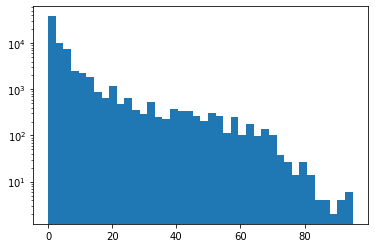

In [9]:
plt.hist(counts_df['count'],bins=40)
plt.yscale('log')
plt.show()

In [10]:
# add a constraint column to the df
eo_lof_dict = { str(constaint.iloc[i,:]['gene']):float(constaint.iloc[i,:]['oe_lof']) 
               for i in range(constaint.shape[0])}
counts_df['constraint'] = [eo_lof_dict[g] if g in eo_lof_dict else None for g in counts_df['gene']]

In [11]:
print(constaint['oe_lof'])
print(counts_df['constraint'])

0        0.0000000
1        0.0066527
2        0.0000000
3        0.0079978
4        0.0000000
           ...    
19699          NaN
19700          NaN
19701          NaN
19702          NaN
19703          NaN
Name: oe_lof, Length: 19704, dtype: float64
0            NaN
1            NaN
2            NaN
3        0.45495
4        0.14639
          ...   
71192    0.41148
71193    0.63691
71194    1.06030
71195    0.29066
71196        NaN
Name: constraint, Length: 71197, dtype: float64


['HNRNPK' 'AHDC1' 'WDR45' 'PHF6' 'PRAF2' 'GRIN2B' 'SATB2' 'GATA6' 'CASK'
 'STXBP1' 'ZIC2']
Haplo extremes: ['SHANK3' 'BCOR' 'AHDC1' 'DYRK1A' 'MBD5' 'MED13L' 'RAI1' 'SETBP1' 'WDR45'
 'HIVEP2' 'MECP2' 'KMT2D']
Olfactory count 108


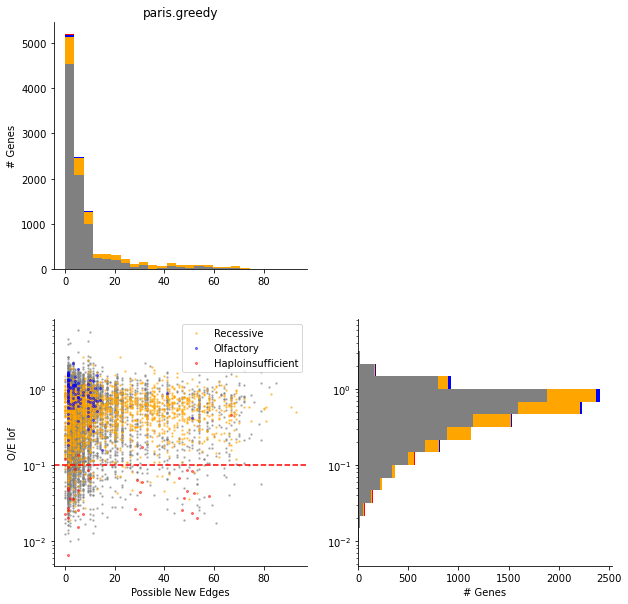

             algo  com     gene  count  haplo haplo_color  recessive_gene  \
465  paris.greedy   93  SHROOM4     74  False        blue           False   
469  paris.greedy   93   ZNF516     79  False        blue           False   
504  paris.greedy  121      NHS     73  False        blue           False   

     olfactory  string_degree   type  constraint  
465      False            196  other    0.098842  
469      False            338  other    0.055946  
504      False            330  other    0.000000  
(3, 11)
['CASK' 'PRAF2' 'SYNGAP1' 'HNRNPK' 'AHDC1' 'WDR45' 'PHF6' 'GRIN2B' 'SATB2'
 'GATA6' 'STXBP1' 'ZIC2']
Haplo extremes: ['SHANK3' 'BCOR' 'AHDC1' 'DYRK1A' 'MBD5' 'MED13L' 'RAI1' 'SETBP1' 'WDR45'
 'HIVEP2' 'MECP2' 'KMT2D']
Olfactory count 112


<Figure size 432x288 with 0 Axes>

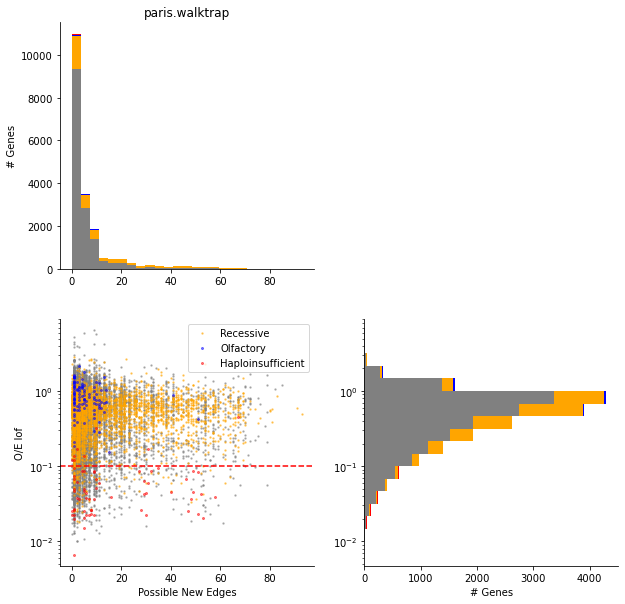

                 algo  com     gene  count  haplo haplo_color  recessive_gene  \
15819  paris.walktrap  360  SHROOM4     74  False        blue           False   
15823  paris.walktrap  360   ZNF516     79  False        blue           False   
15858  paris.walktrap  388      NHS     73  False        blue           False   

       olfactory  string_degree   type  constraint  
15819      False            196  other    0.098842  
15823      False            338  other    0.055946  
15858      False            330  other    0.000000  
(3, 11)
['SATB2' 'GATA6' 'AHDC1' 'STXBP1' 'ZIC2' 'CASK' 'PHF6' 'WDR45' 'SYNGAP1']
Haplo extremes: ['RERE' 'GATA2' 'WDR45' 'CHAMP1' 'SHANK3' 'SYNGAP1' 'MECP2']
Olfactory count 114


<Figure size 432x288 with 0 Axes>

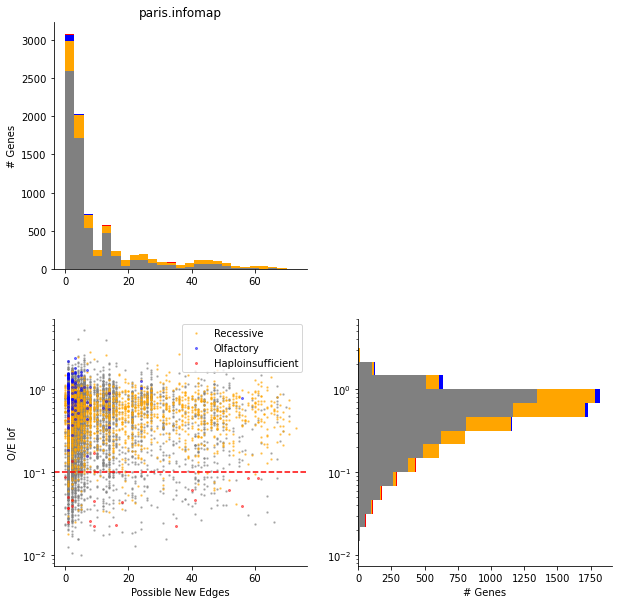

Empty DataFrame
Columns: [algo, com, gene, count, haplo, haplo_color, recessive_gene, olfactory, string_degree, type, constraint]
Index: []
(0, 11)
['GATA6' 'WDR45' 'ZIC2' 'CASK' 'STXBP1' 'GRIN2B' 'PHF6' 'SYNGAP1' 'SATB2'
 'HNRNPK' 'AHDC1']
Haplo extremes: ['DYRK1A']
Olfactory count 10


<Figure size 432x288 with 0 Axes>

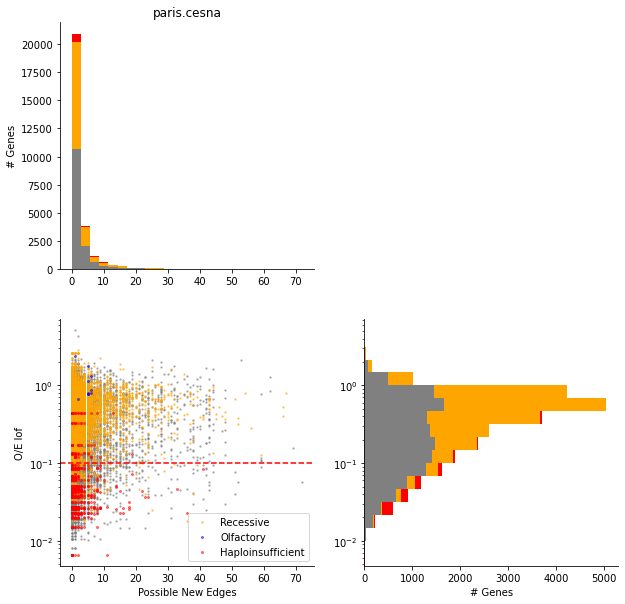

              algo    com   gene  count  haplo haplo_color  recessive_gene  \
69842  paris.cesna  25238  USP47     72  False        blue           False   

       olfactory  string_degree   type  constraint  
69842      False            787  other    0.056706  
(1, 11)


<Figure size 432x288 with 0 Axes>

In [12]:
# plot it, one for each algo, density plots
# print(counts_df['constraint'])

# plot_loghist(sub['constraint'],bins=25,ax=axes[1,1],orientation='horizontal')
for algo in all_names:
    fig, axes = plt.subplots(2,2)
    fig.set_size_inches(10, 10)
    sub = counts_df[counts_df['algo'] == algo]
    sub = sub[~sub['constraint'].isnull()]
    sub = sub[~sub['constraint'].isna()]

    # plot genes that are Haploinsufficient seporately in different colors
    subsub_H = sub[sub['type'] == 'haplo']
    subsub_not_H = sub[sub['type'] == 'other']
    subsub_recessive = sub[sub['type'] == 'recessive_gene']
    subsub_olfactory = sub[sub['type'] == 'olfactory']
    
    print(subsub_H[subsub_H['constraint'] == subsub_H['constraint'].min()]['gene'].unique())
    # what are teh genes that are > 40 < .1 and haplo?
    sssh = subsub_H[subsub_H['constraint'] < .1]
    sssh = sssh[sssh['count'] > 40]
    print('Haplo extremes:', sssh['gene'].unique())
    print('Olfactory count',subsub_olfactory.shape[0])
    axes[1,0].scatter(subsub_not_H['count'],
                      subsub_not_H['constraint'], c='grey', s=2,alpha=.5)
    axes[1,0].scatter(subsub_recessive['count'],
                      subsub_recessive['constraint'], c='orange', s=2,alpha=.5, label='Recessive')
    axes[1,0].scatter(subsub_olfactory['count'],
                      subsub_olfactory['constraint'], c='blue', s=4,alpha=.5, label='Olfactory')
    axes[1,0].scatter(subsub_H['count'],
                      subsub_H['constraint'], c='red', s=4,alpha=.5,label='Haploinsufficient')
    axes[1,0].legend()
    axes[1,0].set_yscale('log')
    colors = ['grey', 'orange', 'blue','red']
    axes[1,1].hist([subsub_not_H['constraint'],
                    subsub_recessive['constraint'],
                    subsub_olfactory['constraint'],
                    subsub_H['constraint']],
                   orientation='horizontal',
                   bins=np.logspace(start=np.log10(.001),stop=np.log10(10),num=25),
                   label=['Other','Recessive','Olfactory','Haploinsufficient'],
                   color=colors,
                   histtype='bar',
                   stacked=True)
    axes[1,1].set_yscale('log')
    axes[1,1].set_ylim(axes[1,0].get_ylim())
#     axes[0,0].hist(sub['count'],orientation='vertical',bins=25)
    axes[0,0].hist([subsub_not_H['count'],
                    subsub_recessive['count'],
                    subsub_olfactory['count'],
                    subsub_H['count']],
                   orientation='vertical',
                   bins=25,
                   label=['Other','Recessive','Olfactory','Haploinsufficient'],
                   color=colors,
                   histtype='bar',
                   stacked=True)
    remove_borders(axes[0,0],bottom=False,left=False)
    remove_borders(axes[1,0],bottom=False,left=False)
    remove_borders(axes[0,1],bottom=False,left=False)
    remove_borders(axes[1,1],bottom=False,left=False)
    axes[0,1].set_visible(False)
    axes[0,0].set_ylabel('# Genes')
    axes[1,0].set_xlabel('Possible New Edges')
    axes[1,1].set_xlabel('# Genes')
    axes[1,0].set_ylabel('O/E lof')
    axes[1,0].axhline(y=0.1,color='red',linestyle='--')
    axes[0,0].set_title(algo)
    plt.savefig('../Figures/constraint_vs_new_edges.stacked.{}.png'.format(algo))
    plt.show()
    plt.clf()
    # print out the genes and clusters that have < .01 o/e and > 40 new edges
    subsub = sub[sub['count'] > 70]
#     print(subsub['constraint'])
    subsub = subsub[subsub['constraint'] < 0.100]
    print(subsub)
    print(subsub.shape)

    

## Stats about haplo genes for paper

In [33]:
print(counts_df.columns)
for algo in all_names:
    sub = counts_df[counts_df['algo'] == algo]
    num_haplo = sum(sub['haplo'])
    subsub = sub[sub['haplo'] == True]
    num_uniq_haplo = len(set(subsub['gene']))
    num_g8r_20 = sum(subsub['count'] > 20)
    print(algo,'\t # haplo:',str(num_haplo),'\t # haplo > 20:',str(num_g8r_20),'\t # uniq haplo genes:', num_uniq_haplo)
    print(num_g8r_20,'/',num_haplo, ' in ',algo)

olf_genes_g8r_20_in_all = []
for algo in all_names:
    sub = counts_df[counts_df['algo'] == algo]
    num_olf = sum(sub['olfactory'])
    subsub = sub[sub['olfactory'] == True]
    num_uniq_olf = len(set(subsub['gene']))
    num_g8r_20_olf = sum(subsub['count'] > 20)
    sub3 = subsub[subsub['count'] > 20]
    print(algo,'\t # olfactory:',str(num_olf),'\t # olfactory > 20:',str(num_g8r_20_olf),'\t # uniq olfactory genes:', num_uniq_olf)
    print(num_g8r_20_olf,'/',num_olf, ' in ',algo)
    print('olf genes > 20', sub3['gene'])
    for g in sub3['gene']:
        olf_genes_g8r_20_in_all.append(g)

print(olf_genes_g8r_20_in_all)
print(set(olf_genes_g8r_20_in_all))
    

Index(['algo', 'com', 'gene', 'count', 'haplo', 'haplo_color',
       'recessive_gene', 'olfactory', 'string_degree', 'type', 'constraint'],
      dtype='object')
paris.greedy 	 # haplo: 48 	 # haplo > 20: 21 	 # uniq haplo genes: 48
21 / 48  in  paris.greedy
paris.walktrap 	 # haplo: 85 	 # haplo > 20: 29 	 # uniq haplo genes: 52
29 / 85  in  paris.walktrap
paris.infomap 	 # haplo: 31 	 # haplo > 20: 12 	 # uniq haplo genes: 31
12 / 31  in  paris.infomap
paris.cesna 	 # haplo: 879 	 # haplo > 20: 7 	 # uniq haplo genes: 55
7 / 879  in  paris.cesna
paris.greedy 	 # olfactory: 124 	 # olfactory > 20: 3 	 # uniq olfactory genes: 124
3 / 124  in  paris.greedy
olf genes > 20 7497      OR5AK2
10033     OR11L1
10034    OR14A16
Name: gene, dtype: object
paris.walktrap 	 # olfactory: 131 	 # olfactory > 20: 3 	 # uniq olfactory genes: 127
3 / 131  in  paris.walktrap
olf genes > 20 22951     OR5AK2
25487     OR11L1
25488    OR14A16
Name: gene, dtype: object
paris.infomap 	 # olfactory: 123 	 # 

## Combine 4 into 1


In [14]:
fig_files = ['../Figures/constraint_vs_new_edges.stacked.paris.greedy.png',
'../Figures/constraint_vs_new_edges.stacked.paris.walktrap.png',
'../Figures/constraint_vs_new_edges.stacked.paris.infomap.png',
'../Figures/constraint_vs_new_edges.stacked.paris.cesna.png']
images = [Image.open(x) for x in fig_files]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (int(total_width/2), int(max_height*2)))
letters = ['A','B','C','D']
for i,im in enumerate(images):
    w = int(i/2) * max_height
    h = int(i%2) * widths[0]
#     im=Image.open(elem)
    new_im.paste(im, (h,w))
    I1 = ImageDraw.Draw(new_im)
    myFont = ImageFont.truetype('../arial.ttf', 32)
    off_set = 32
    I1.text((h+off_set, w+off_set), letters[i], font=myFont, fill=(0, 0, 0))

new_im.save('../Figures/constraint_vs_new_edges.stacked.all.png')

# x_offset = 0
# for im in images:
#   new_im.paste(im, (x_offset,0))
#   x_offset += im.size[0]

# new_im.save('test.jpg')


/var/folders/ty/694s8g7n1cz_l5s3prx55jzr0000gn/T/ipykernel_9109/311086439.py:10: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(points)


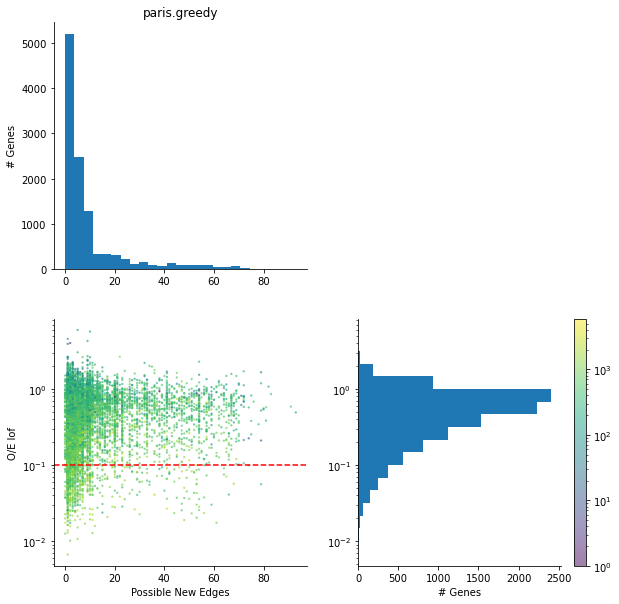

<Figure size 432x288 with 0 Axes>

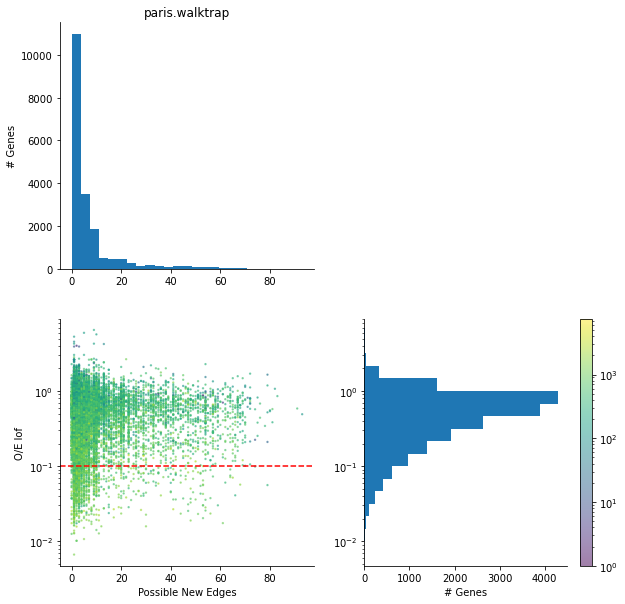

<Figure size 432x288 with 0 Axes>

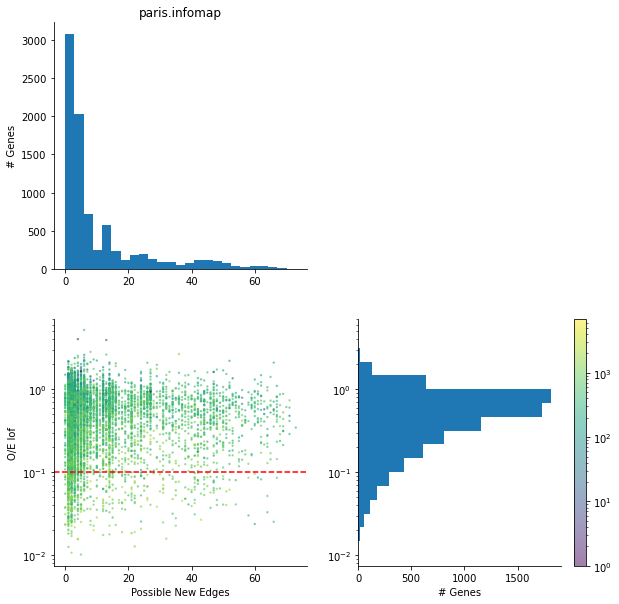

<Figure size 432x288 with 0 Axes>

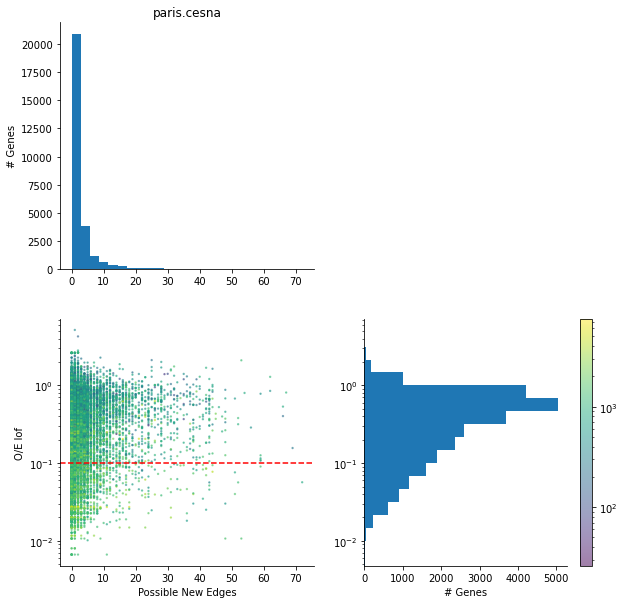

<Figure size 432x288 with 0 Axes>

In [15]:
# Plot possible new edges vs contraint colored by STRING degree
for algo in all_names:
    fig, axes = plt.subplots(2,2)
    fig.set_size_inches(10, 10)
    sub = counts_df[counts_df['algo'] == algo]
    sub = sub[~sub['constraint'].isnull()]
    sub = sub[~sub['constraint'].isna()]

    points = axes[1,0].scatter(sub['count'],sub['constraint'],c=sub['string_degree'], s=2,alpha=.5,norm=matplotlib.colors.LogNorm())
    fig.colorbar(points)
    axes[1,0].set_yscale('log')
    axes[1,1].hist(sub['constraint'],orientation='horizontal',
                   bins=np.logspace(start=np.log10(.001), stop=np.log10(10), num=25))
    axes[1,1].set_yscale('log')
    axes[1,1].set_ylim(axes[1,0].get_ylim())
    axes[0,0].hist(sub['count'],orientation='vertical',bins=25)
    remove_borders(axes[0,0],bottom=False,left=False)
    remove_borders(axes[1,0],bottom=False,left=False)
    remove_borders(axes[0,1],bottom=False,left=False)
    remove_borders(axes[1,1],bottom=False,left=False)
    axes[0,1].set_visible(False)
    axes[0,0].set_ylabel('# Genes')
    axes[1,0].set_xlabel('Possible New Edges')
    axes[1,1].set_xlabel('# Genes')
    axes[1,0].set_ylabel('O/E lof')
    axes[1,0].axhline(y=0.1,color='red',linestyle='--')
    axes[0,0].set_title(algo)
    plt.savefig('../Figures/constraint_vs_new_edges_STRING_degree.{}.png'.format(algo))
    plt.show()
    plt.clf()


    

In [16]:
# ratio of discoverable edges to all possible edges edges
possible_discovery_data = {'algo':[],'cluster':[],'possible':[],'observed':[],'ratio':[],'size':[],'g2h_ratio':[]}
for coms,name in zip(all_coms,all_names):
    for com in coms:
        genes = com.get_genes()
        hpos = [n for n in com.members if n not in genes]
        if len(genes) == 0 or len(hpos) == 0:
            continue
        possible_edges = len(genes) * len(hpos)
        count = 0
        for g in genes:
            for h in hpos:
                if not G21.has_edge(g,h):
                    count += 1
        possible_discovery_data['algo'].append(name)
        possible_discovery_data['cluster'].append(com.name)
        possible_discovery_data['possible'].append(possible_edges)
        possible_discovery_data['observed'].append(count)
        possible_discovery_data['ratio'].append(count/possible_edges)
        possible_discovery_data['size'].append(len(com.members))
        possible_discovery_data['g2h_ratio'].append(len(genes)/len(hpos))

possible_df = pd.DataFrame(possible_discovery_data)
print(possible_df)
print(possible_df)
print(possible_df.shape)
print(possible_df.columns)

              algo cluster  possible  observed       ratio  size   g2h_ratio
0     paris.greedy      42        60        46  0.76666667    23  0.15000000
1     paris.greedy      43       944       935  0.99046610    75  0.27118644
2     paris.greedy      44       232       222  0.95689655    62  0.06896552
3     paris.greedy      45       912       768  0.84210526    88  0.15789474
4     paris.greedy      46        60        58  0.96666667    61  0.01666667
...            ...     ...       ...       ...         ...   ...         ...
3804   paris.cesna   26497       144        85  0.59027778    30  4.00000000
3805   paris.cesna   26498        16         3  0.18750000     8  1.00000000
3806   paris.cesna   26507        24        23  0.95833333    14  6.00000000
3807   paris.cesna   26508        16        12  0.75000000    10  0.25000000
3808   paris.cesna   26511        19        13  0.68421053    20  0.05263158

[3809 rows x 7 columns]
              algo cluster  possible  observed     

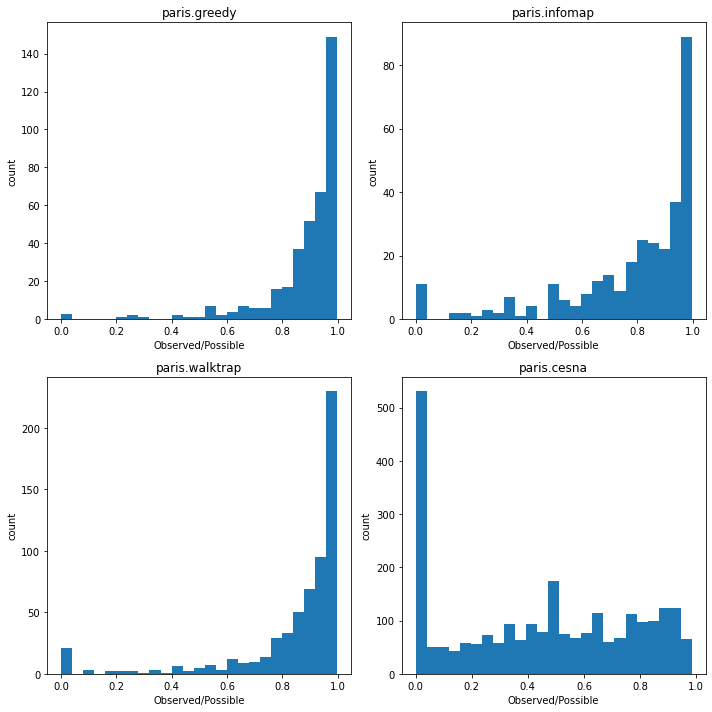

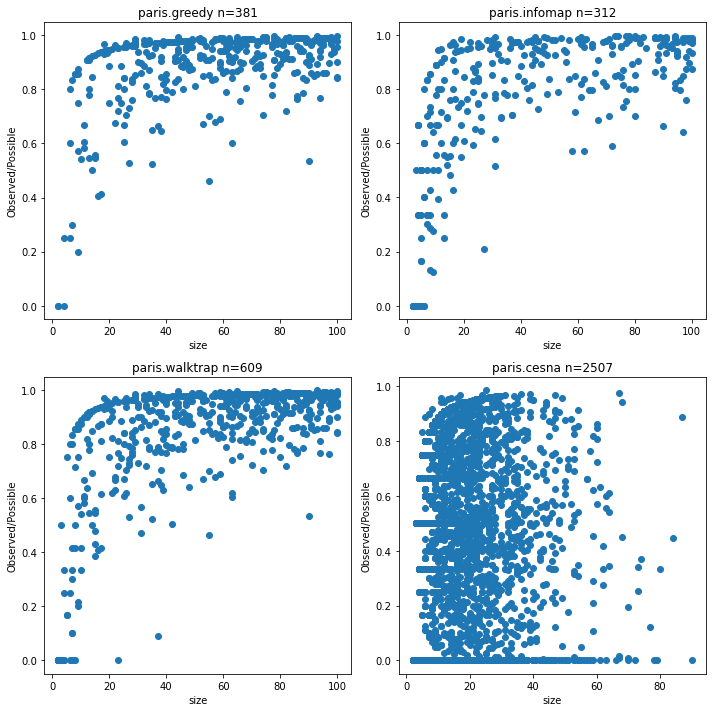

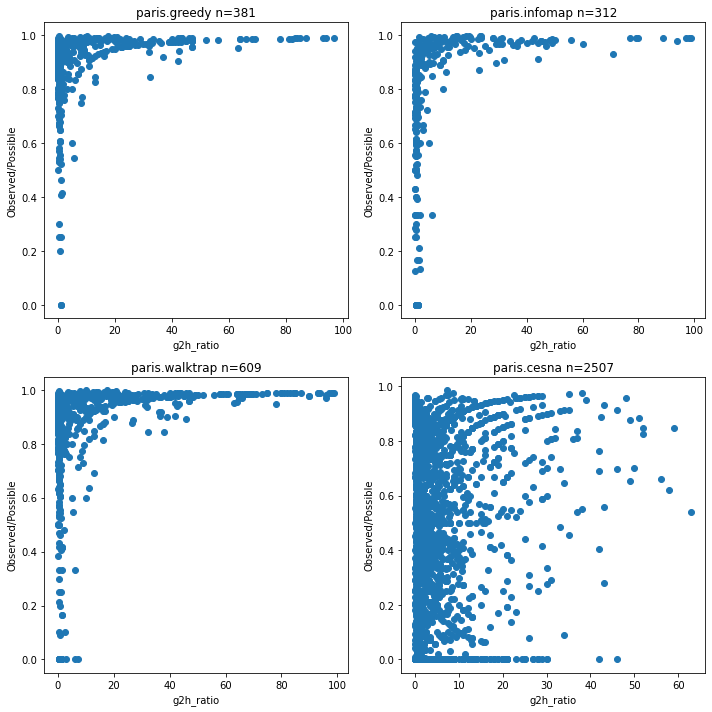

In [17]:
# dist of ratios
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10, 10)
for i,algo in enumerate(possible_df['algo'].unique()):
    sub = possible_df[possible_df['algo'] == algo]
    axes[i%2,int(i/2)].hist(sub['ratio'],bins=25)
    axes[i%2,int(i/2)].set_xlabel('Observed/Possible')
    axes[i%2,int(i/2)].set_ylabel('count')
    axes[i%2,int(i/2)].set_title(algo)
plt.tight_layout()
plt.savefig('../Figures/possible_edges_ratios.png')
plt.show()


# dist of ratios
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10, 10)
for i,algo in enumerate(possible_df['algo'].unique()):
    sub = possible_df[possible_df['algo'] == algo]
    axes[i%2,int(i/2)].scatter(sub['size'],sub['ratio'])
    axes[i%2,int(i/2)].set_xlabel('size')
    axes[i%2,int(i/2)].set_ylabel('Observed/Possible')
    axes[i%2,int(i/2)].set_title(algo + ' n={}'.format(str(sub.shape[0])))
plt.tight_layout()
plt.savefig('../Figures/possible_edges_v_size_scatter.png')
plt.show()


# dist of ratios
fig, axes = plt.subplots(2,2)
fig.set_size_inches(10, 10)
for i,algo in enumerate(possible_df['algo'].unique()):
    sub = possible_df[possible_df['algo'] == algo]
    axes[i%2,int(i/2)].scatter(sub['g2h_ratio'],sub['ratio'])
    axes[i%2,int(i/2)].set_xlabel('g2h_ratio')
    axes[i%2,int(i/2)].set_ylabel('Observed/Possible')
    axes[i%2,int(i/2)].set_title(algo + ' n={}'.format(str(sub.shape[0])))
plt.tight_layout()
plt.savefig('../Figures/possible_edges_v_gene2hpo_scatter.png')
plt.show()

In [18]:
# what are the O/P ratios of the MyGene2 discoveries
mg2_algos = ['paris.walktrap','paris.greedy','paris.cesna','paris.cesna','paris.walktrap','paris.cesna','paris.cesna','paris.cesna','paris.cesna','paris.cesna','paris.cesna','paris.cesna','paris.cesna','paris.walktrap','paris.greedy','paris.cesna','paris.cesna','paris.cesna','paris.cesna','paris.cesna','paris.cesna']
mg2_ids = [1321 ,968 ,22018 ,15553 ,84 ,9175 ,3199 ,9175 ,14105 ,5816 ,6379 ,6379 ,24074 ,745 ,420 ,24123 ,24123 ,1940 ,15778 ,21373 ,24273]

for a,i in zip(mg2_algos,mg2_ids):
    sub = possible_df[possible_df['algo'] == a]
    print(sub[sub['cluster'] == str(i)])


               algo cluster  possible  observed       ratio  size   g2h_ratio
814  paris.walktrap    1321       272       215  0.79044118    42  0.23529412
             algo cluster  possible  observed       ratio  size   g2h_ratio
360  paris.greedy     968       272       215  0.79044118    42  0.23529412
             algo cluster  possible  observed  ratio  size   g2h_ratio
3358  paris.cesna   22018        75        63   0.84    28  8.33333333
             algo cluster  possible  observed       ratio  size  g2h_ratio
2766  paris.cesna   15553       198        83  0.41919192    39        5.5
               algo cluster  possible  observed       ratio  size  g2h_ratio
406  paris.walktrap      84       180       177  0.98333333    63       20.0
             algo cluster  possible  observed       ratio  size   g2h_ratio
2187  paris.cesna    9175       624       214  0.34294872    64  4.33333333
             algo cluster  possible  observed       ratio  size   g2h_ratio
1605  paris.cesna 